# Null Importanceによる特徴量選択

- null importanceでは、ラベルデータをシャッフルする場合とシャッフルしない場合での特徴量重要度を取得する。
- 上記の特徴量重要度を比較することで、以下のようなことが言える。
    - ラベルデータがシャッフルされることで特徴量重要度が低くなれば重要である。
    - ラベルデータがシャッフルされることで特徴量重要度が同じ、もしくは、高くなるこおｔがあれば、重要度出ない。
    
 
## 結果

今回使ったデモデータでは、精度の向上は確認できなかった。

In [12]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

## 全データを使った場合の予測精度
- 5-fold CV
- Random Forest

In [113]:
cancer = datasets.load_breast_cancer()

df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

X = df.drop('target', axis=1)
y = df['target']

cv = StratifiedKFold(n_splits=5, shuffle=True)
model = RandomForestClassifier()
cv_scores = cross_val_score(model, X, y, cv=cv)

print(f'Cross-validation scores: ')
print(f'\tMEAN: {np.mean(cv_scores)}')
print(f'\tSTD: {np.std(cv_scores)}')

Cross-validation scores: 
	MEAN: 0.9613879832324173
	STD: 0.01803688197632531


## Null Importanceを用いて特徴量を減らしたあとの精度
- 5-fold CV
- Random Forest

In [93]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


class Null_Importance():
    def __init__(self, df, features, target, n_run, seed=42):
        self.seed = seed
        self.df = df
        self.features = features
        self.target = target
        self.importance_df = self.fit(n_run)
        
    
    def fit(self, n_run):
        importance_df = pd.DataFrame({'feature': features})
        X = self.df[self.features].values
        y = self.df[self.target].values
        
        train_data = self.convert_dataset(X, y)
        model = self.train_model(train_data)
        importance_df['actual_importance'] = self.get_feature_importace(model)
        
        for i in tqdm(range(n_run)):
            shuffled_y = np.random.permutation(y)
            train_data = self.convert_dataset(X, shuffled_y)
            model = self.train_model(train_data)
            importance_df[f'{i+1}_run_importance'] = self.get_feature_importace(model)
        
        return importance_df
    
    def train_model(self, train_data):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting': 'gbdt',
            'n_estimators': 100,
            'learning_rate': 0.1,
            'num_leaves': 32,
            'max_depth': 5,
            'min_data_in_leaf': 20,
            'bagging_fraction': 1.0,
            'early_stopping_round': 10,
            'seed': self.seed
        }
        model = lgb.train(params, train_data, valid_sets=train_data, verbose_eval=0)
        return model
    
    
    def get_feature_importace(self, model):
        return model.feature_importance()
    
    
    def convert_dataset(self, X, y):
        return lgb.Dataset(X, y)
    
    
    def get_unimportance_features(self, threshold = 80):
        unimport_features = []
        for feat in self.features:
            feat_df = self.importance_df.query('feature == @feat')
            acutual_val = feat_df['actual_importance'].values
            null_vals = feat_df.iloc[:, 2:].values.ravel()
            typical_null_val = np.percentile(null_vals, threshold)
            if acutual_val <= typical_null_val:
                unimport_features.append(feat)
        return unimport_features
    
    
    def display_importance(self, figsize=(7, 10)):
        imp_df = self.importance_df[['feature', 'actual_importance']].sort_values(by='actual_importance')
        plt.figure(figsize=figsize)
        plt.barh(imp_df['feature'], imp_df['actual_importance'])
        plt.xlabel("Feature Importance")
        plt.show()
    
    
    def display_distributions(self, feature):
        feat_df = self.importance_df.query('feature == @feature')
        acutual_val = feat_df['actual_importance'].values
        null_vals = feat_df.iloc[:, 2:].values.ravel()

        plt.figure()
        ax = plt.hist(null_vals, label='Null Importance', color='tab:blue')
        plt.title(f"Importance of {feature}")
        plt.xlabel(f"Null Importance Distribution for {feature}")
        plt.vlines(x=acutual_val, ymin=0, ymax=np.max(ax[0]), color='red', linewidth=10, label='Real Importance')
        plt.legend()
        plt.show()

In [100]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

features = cancer.feature_names
target = 'target'
n_run = 100

null_imp = Null_Importance(df, features, target, n_run, seed=9)

/Users/rui/.local/share/virtualenvs/data_science_bowl-_c7OiX6v/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/rui/.local/share/virtualenvs/data_science_bowl-_c7OiX6v/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [101]:
# 取得したDataFrame
print(null_imp.importance_df.shape)
null_imp.importance_df.head()

(30, 102)


,feature,actual_importance,1_run_importance,2_run_importance,3_run_importance,4_run_importance,5_run_importance,6_run_importance,7_run_importance,8_run_importance,...,91_run_importance,92_run_importance,93_run_importance,94_run_importance,95_run_importance,96_run_importance,97_run_importance,98_run_importance,99_run_importance,100_run_importance
0,mean radius,7,8,12,4,13,14,14,17,14,...,4,15,8,16,7,7,9,17,6,11
1,mean texture,28,31,30,75,46,46,19,26,50,...,33,61,42,22,50,15,33,28,35,46
2,mean perimeter,9,13,3,16,12,17,6,3,15,...,14,10,13,16,6,12,9,12,8,4
3,mean area,1,8,8,7,7,4,2,15,5,...,9,8,6,12,15,11,8,19,4,13
4,mean smoothness,10,65,46,40,27,24,41,36,24,...,19,40,46,35,26,31,35,51,41,51


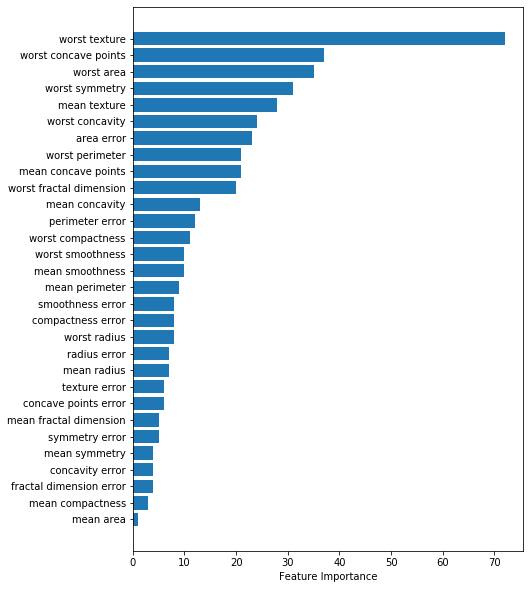

In [102]:
# 特徴量重要度の可視化
null_imp.display_importance(figsize=(7, 10))

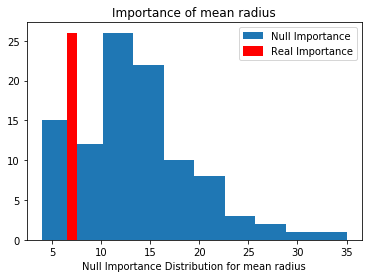

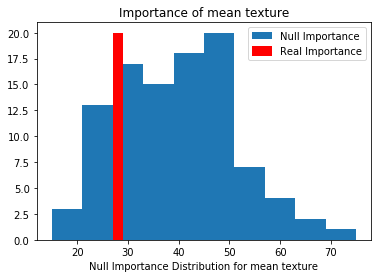

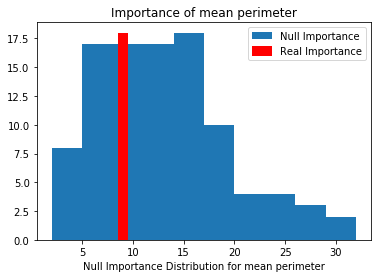

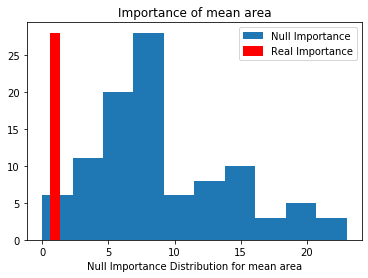

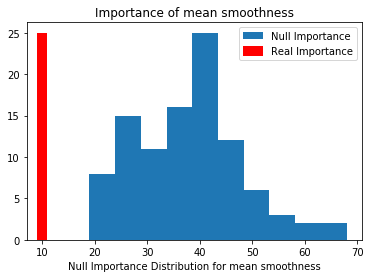

In [103]:
# null importanceの結果を特定のfeatureごとに可視化
# feature = 'mean radius'
for f in features[:5]:
    null_imp.display_distributions(f)

In [114]:
drop_cols = null_imp.get_unimportance_features(threshold=50)
print(f'num of drop columns is {len(drop_cols)}')
drop_cols

num of drop columns is 26


['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst radius',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst symmetry',
 'worst fractal dimension']

In [115]:
X = df.drop(drop_cols+['target'], axis=1)
y = df['target']

cv = StratifiedKFold(n_splits=5, shuffle=True)
model = RandomForestClassifier()
cv_scores = cross_val_score(model, X, y, cv=cv)

print(f'Cross-validation scores: {np.mean(cv_scores)}')
print(f'\tMEAN: {np.mean(cv_scores)}')
print(f'\tSTD: {np.std(cv_scores)}')

Cross-validation scores: 0.9595870206489675
	MEAN: 0.9595870206489675
	STD: 0.011871973088911152
